<a href="https://colab.research.google.com/github/BrandonFylnn/google-landmark/blob/master/ResNet50_V1_(Beta).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Keras Resnet-50 for Pneumonia

# TPU

to utilize TPUs efficiently, be sure to change the Accelerator to TPU

In [1]:
# import re
# import os
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# # from kaggle_datasets import KaggleDatasets
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)
    
# print(tf.__version__)

# 1. Load the Necessary Packages 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# 2. Load dataset

In [4]:
# Path to data

# data_dir  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
#data_dir  = '../input/chest-xray-covid19-pneumonia/Data/'

data_dir = '/content/drive/Shared drives/Senior project/cxr-covid19/Data'
train_dir = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/train'  #data_dir+'train/'
test_dir  = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/test' # data_dir+'test/'
val_dir   = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/val'  # data_dir + 'val/'

# Get the path to the normal & pneumonia & covid sub-directories
normal_cases_dir = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/train/NORMAL/'
pneumonia_cases_dir = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/train/PNEUMONIA/'
covid_cases_dir = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/train/COVID19/'

print("Datasets:",os.listdir(data_dir))
print("Train:\t", os.listdir(train_dir))
print("Test:\t", os.listdir(test_dir))
print("Val:\t", os.listdir(val_dir))

Datasets: ['test', 'train', 'val']
Train:	 ['PNEUMONIA', 'NORMAL', 'COVID19']
Test:	 ['NORMAL', 'COVID19', 'PNEUMONIA']
Val:	 ['PNEUMONIA', 'COVID19', 'NORMAL']


In [5]:
# CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
#                         for item in tf.io.gfile.glob(str("/content/drive/Shared drives/Senior project/cxr-covid19/Data/train/*"))])
# CLASS_NAMES

**Run the following cell to see if we have an imbalance in our data.**

In [6]:
train_filenames = tf.io.gfile.glob(str('/content/drive/Shared drives/Senior project/cxr-covid19/Data/train/*/*'))

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal    images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

COUNT_COVID = len([filename for filename in train_filenames if "COVID19" in filename])
print("COVID-19  images count in training set: " + str(COUNT_COVID))

print("\nTotal     images count in training set: " + str(COUNT_COVID + COUNT_PNEUMONIA + COUNT_NORMAL))

Normal    images count in training set: 886
Pneumonia images count in training set: 2392
COVID-19  images count in training set: 315

Total     images count in training set: 3593


**Notice that the there are way more images that are classified as pneumonia than the others. This shows that we have an imbalance in our data. We will correct for this imbalance later on in our notebook.**

In [7]:
# # train_filenames = tf.io.gfile.glob(str('/content/drive/Shared drives/Senior project/cxr-covid19/Data/train/*/*'))
# val_filenames = = tf.io.gfile.glob(str('/content/drive/Shared drives/Senior project/cxr-covid19/Data/val/*/*'))

# train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
# val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# for f in train_list_ds.take(5):
#     print(f.numpy())

# 3. Visualize the dataset

NORMAL


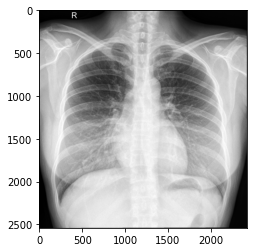

In [8]:
img_name = 'NORMAL(987).jpg'
img_normal = load_img(normal_cases_dir + img_name)

print('NORMAL')
plt.imshow(img_normal)

plt.show()

PNEUMONIA


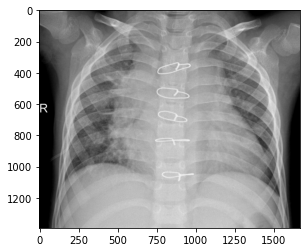

In [9]:
img_name = 'PNEUMONIA(946).jpg'
img_pneumonia = load_img(pneumonia_cases_dir + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)

plt.show()

COVID-19


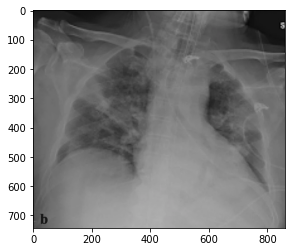

In [10]:
img_name = 'COVID19(74).jpg'
img_covid = load_img(covid_cases_dir + img_name)

print('COVID-19')
plt.imshow(img_covid)

plt.show()

**Looking at the data**

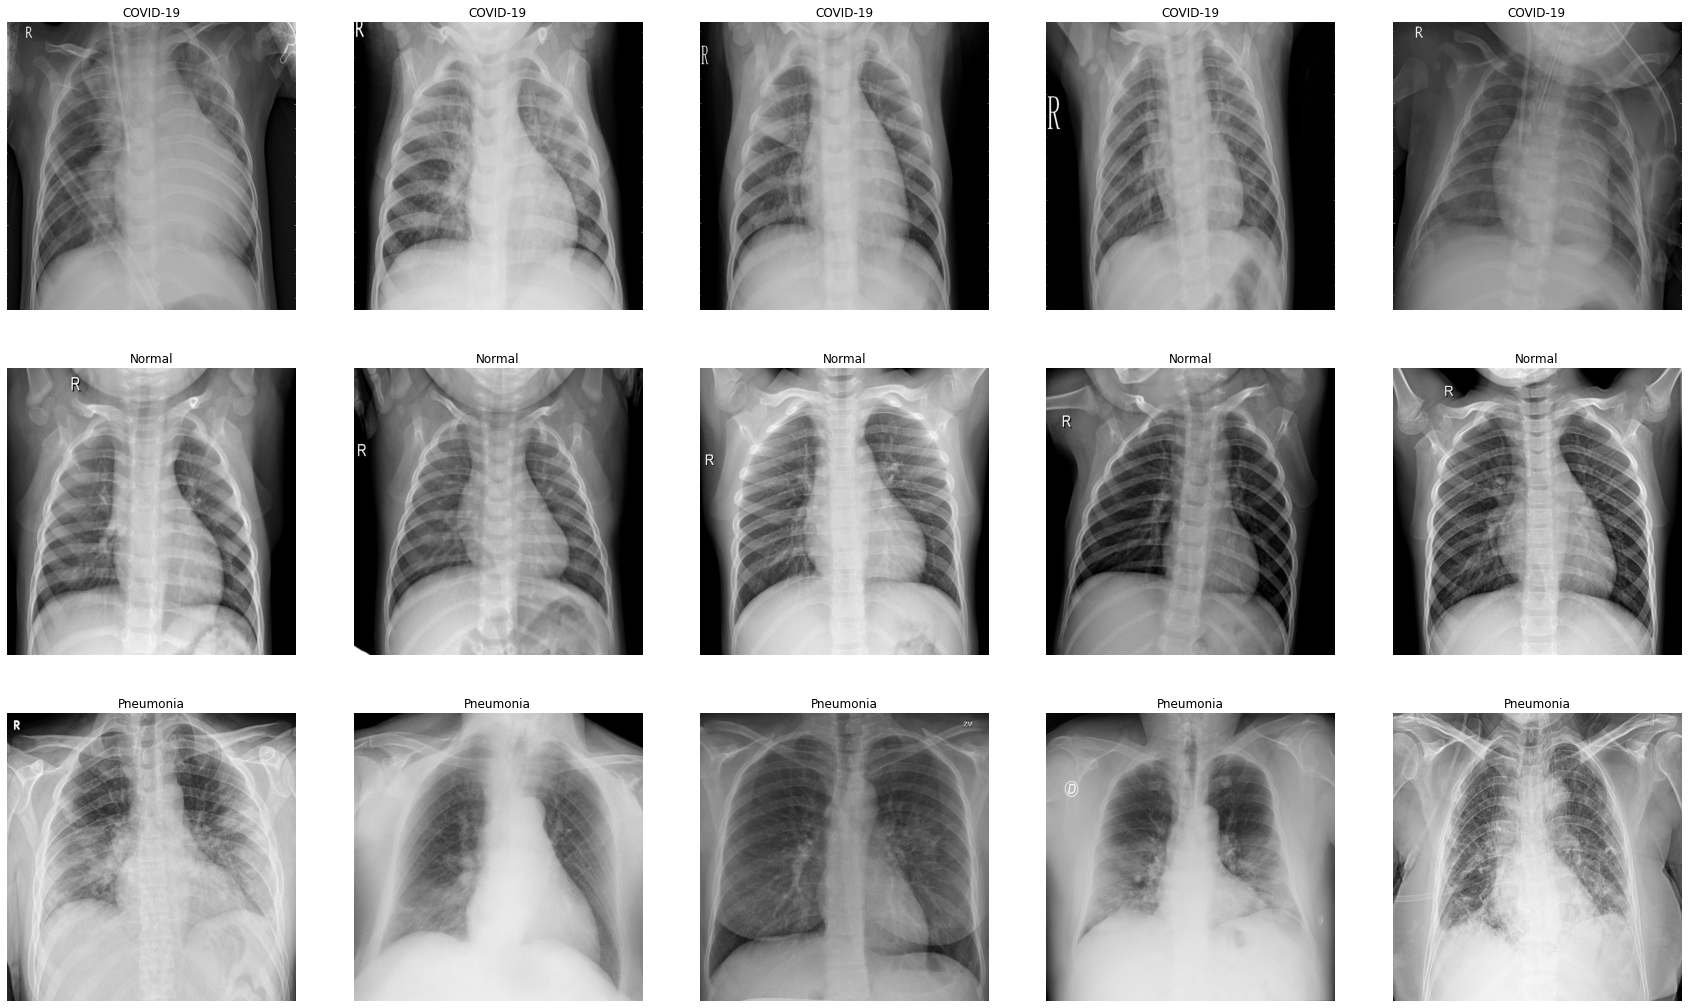

In [11]:
normal_cases = glob(normal_cases_dir+'/*.jpg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpg')
covid_cases = glob(covid_cases_dir+'/*.jpg')  # aof

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img,1))

# Go through all the covid cases. The label for these cases will be 2   | aof
for img in covid_cases:
    train_data.append((img,2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes

pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()  
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist() # | aof

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples + covid_samples
del pneumonia_samples, normal_samples, covid_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,18))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("COVID-19")
        
    elif i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Pneumonia") #mint
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

# 4. Build the CNN

In [12]:
num_classes = 3
# resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224,224,3)))

# model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94773248/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


**Fit the model using data augmentation**

In [13]:
image_size = 150
nb_train_samples = 3593 # number of files in training set
batch_size = 16

EPOCHS = 30
STEPS = nb_train_samples / batch_size

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input            
                                          )

train_generator = data_generator_with_aug.flow_from_directory(
       directory = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/train',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/val',
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = '/content/drive/Shared drives/Senior project/cxr-covid19/Data/test',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

history = model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = EPOCHS,
       steps_per_epoch=STEPS, verbose =2,
       validation_data= validation_generator) # specify where model gets validation data

# Evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Found 3593 images belonging to 3 classes.
Found 1551 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
225/224 - 3457s - loss: 0.5733 - accuracy: 0.8503 - val_loss: 0.2028 - val_accuracy: 0.9233
Epoch 2/30
225/224 - 105s - loss: 0.2782 - accuracy: 0.9084 - val_loss: 0.2924 - val_accuracy: 0.8897
Epoch 3/30
225/224 - 106s - loss: 0.2722 - accuracy: 0.9159 - val_loss: 0.2311 - val_accuracy: 0.9226
Epoch 4/30
225/224 - 106s - loss: 0.2484 - accuracy: 0.9154 - val_loss: 0.3228 - val_accuracy: 0.8981
Epoch 5/30
225/224 - 105s - loss: 0.2491 - accuracy: 0.9193 - val_loss: 0.2095 - val_accuracy: 0.9284
Epoch 6/30
225/224 - 107s - loss: 0.1951 - accuracy: 0.9338 - val_loss: 0.1597 - val_accuracy: 0.9452
Epoch 7/30
225/224 - 106s - loss: 0.1911 - accuracy: 0.9307 - val_loss: 0.2964 - val_accuracy: 0.8962
Epoch 8/30
225/224 - 106s - loss: 0.1779 - accuracy: 0.9393 - val_loss: 0.5967 - va

In [14]:
from tensorflow.python.keras.models import load_model
model.save('xray_model3.h5')
model = load_model('xray_model3.h5')

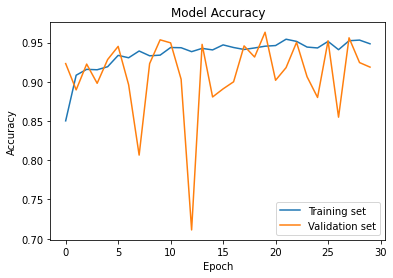

In [15]:
33# Accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='lower right')
plt.legend(['Training set', 'Validation set'], loc='lower right')
plt.show()

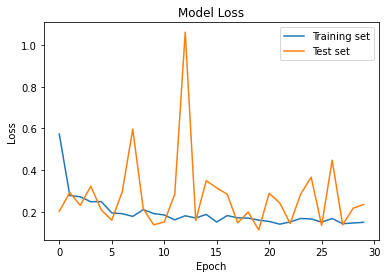

In [16]:
# Loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper right')
plt.show()

In [17]:
# fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# ax = ax.ravel()

# for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#     ax[i].plot(history.history[met])
#     ax[i].plot(history.history['val_' + met])
#     ax[i].set_title('Model {}'.format(met))
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])

**Make Predictions**

Actual class: COVID
Predicted class: Normal
Likelihood: 0.9999


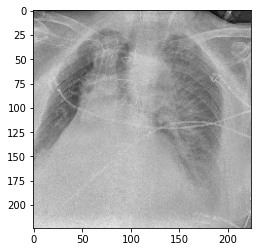

In [31]:
def choose_image_and_predict():  
    normal_or_pneumonia = ['NORMAL', 'PNEUMONIA', 'COVID']
    folder_choice = (random.choice(normal_or_pneumonia))

    pneumonia_images_path = glob('/content/drive/Shared drives/Senior project/cxr-covid19/Data/test/COVID19/*.jpg')
    pneumonia_images = []
    for p_img in pneumonia_images_path:
      pneumonia_images.append(p_img)
    img_choice = (random.choice(pneumonia_images)) #mint

    img = load_img(img_choice, target_size=(224, 224))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_class = model.predict_classes(x)
    pred = model.predict(x)
    print("Actual class:", folder_choice)
    if pred_class[0] == 0:
        print("Predicted class: Normal")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    elif pred_class[0] == 2:
        print("Predicted class: COVID-19")
        print("Likelihood:", pred[0][2].round(4))
        if pred[0][2].round(4) < 0.8:
            print("WARNING, low confidence")
    else:
        print("Predicted class: Pneumonia")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence")        
        
choose_image_and_predict()